In [2]:
!pip install -U -q jupyter_client ipykernel

# PPO (Proximal Policy Optimization) 强化学习教程
## 在 CartPole 环境中训练智能体

本教程将带你实现PPO算法，在经典的CartPole环境中训练一个能够平衡杆子的智能体。PPO是目前最稳定高效的策略优化算法之一，广泛应用于游戏AI、机器人控制等领域。

> **核心思想**：通过限制策略更新的幅度，确保训练过程稳定，同时保持高效的策略改进能力。

## 1. 核心工具模块 (rl_utils.py)

这个模块包含了强化学习训练的核心组件：
- **ReplayBuffer**: 经验回放缓冲区（用于off-policy算法）
- **moving_average**: 计算滑动平均，用于平滑学习曲线
- **train_on_policy_agent**: on-policy训练框架（适用于PPO、A2C等）
- **train_off_policy_agent**: off-policy训练框架（适用于DQN、SAC等）
- **compute_advantage**: 计算GAE（Generalized Advantage Estimation）优势函数

In [119]:
# rl_utils.py文件
%%writefile rl_utils.py
from tqdm import tqdm
import numpy as np
import torch
import collections
import random

class ReplayBuffer:
    """经验回放缓冲区，用于存储和采样智能体的经验"""
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """添加一条经验到缓冲区"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """随机采样batch_size条经验"""
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        """返回缓冲区中经验的数量"""
        return len(self.buffer)

def moving_average(a, window_size):
    """计算滑动平均，用于平滑学习曲线"""
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    """
    训练on-policy智能体（如PPO、A2C）

    参数:
    env: Gymnasium环境
    agent: 智能体对象（需实现take_action和update方法）
    num_episodes: 总训练回合数

    返回:
    return_list: 每个episode的累积奖励列表
    """
    return_list = []
    # 每一大轮包含多少个episode
    episodes_per_iteration = int(num_episodes/10)

    for i in range(10):
        with tqdm(total=episodes_per_iteration, desc='Iteration %d' % i) as pbar:
            for i_episode in range(episodes_per_iteration):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    # 存储经验
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)

                    state = next_state
                    episode_return += reward

                return_list.append(episode_return)
                agent.update(transition_dict) # 更新智能体

                # 新增计算全局进度并调用衰减
                current_global_episode = i * episodes_per_iteration + i_episode
                agent.lr_decay(num_episodes, current_global_episode)

                # 每10个episode显示一次平均回报
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes/10 * i + i_episode+1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    """
    训练off-policy智能体（如DQN、SAC）
    """
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward

                    # 当缓冲区足够大时开始训练
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s, 'actions': b_a, 'next_states': b_ns,
                            'rewards': b_r, 'dones': b_d
                        }
                        agent.update(transition_dict)

                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes/10 * i + i_episode+1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    """
    计算GAE (Generalized Advantage Estimation) 优势函数

    参数:
    gamma: 折扣因子
    lmbda: GAE参数，控制偏差-方差权衡
    td_delta: TD误差列表

    返回:
    优势函数张量
    """
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0

    # 从后向前计算GAE
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


Overwriting rl_utils.py


## 2. PPO算法实现

PPO (Proximal Policy Optimization) 是一种先进的策略优化算法，通过引入**截断机制**确保策略更新的稳定性。

### 网络架构
- **PolicyNet (Actor)**: 将状态映射到动作概率分布
- **ValueNet (Critic)**: 估计状态价值函数 V(s)

### PPO核心机制
1. **重要性采样比值**: `ratio = π_new(a|s) / π_old(a|s)`
2. **截断机制**: 限制策略更新幅度，防止性能崩溃
3. **GAE (Generalized Advantage Estimation)**: 平衡偏差和方差的优势函数估计

### 训练流程
1. 收集轨迹数据
2. 计算优势函数
3. 多次迭代更新策略网络和价值网络
4. 重复直到收敛

In [6]:
import gymnasium as gym # 强化学习环境
import torch
import torch.nn.functional as F # 提供无状态的神经网络函数
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [11]:
class PolicyNet(torch.nn.Module):
    """策略网络 (Actor): 将状态映射到动作概率分布"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 输入层到隐藏层
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim) # 隐藏层到输出层

    def forward(self, x):
        """前向传播"""
        x = F.relu(self.fc1(x)) # ReLU激活函数
        return F.softmax(self.fc2(x), dim=1) # Softmax输出概率分布


class ValueNet(torch.nn.Module):
    """价值网络 (Critic): 估计状态价值函数 V(s)"""
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """前向传播"""
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # 线性输出（价值估计）


class PPO:
    ''' PPO算法实现，采用截断方式 (PPO-Clip) '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        """
        初始化PPO智能体

        参数:
        state_dim: 状态维度
        hidden_dim: 隐藏层维度
        action_dim: 动作维度
        actor_lr: 策略网络学习率
        critic_lr: 价值网络学习率
        lmbda: GAE参数
        epochs: 每条轨迹的训练轮数
        eps: PPO截断范围参数
        gamma: 折扣因子
        device: 计算设备 (CPU/GPU)
        """
        # 创建网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        # 优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        # 算法参数
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 每条轨迹训练轮数
        self.eps = eps     # PPO截断范围 [1-ε, 1+ε]
        self.device = device

    def take_action(self, state):
        """
        根据当前策略选择动作

        参数:
        state: 当前状态 (numpy数组)

        返回:
        action: 选择的动作 (整数)
        """
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device) # state先转numpy数组再转tensor效率更快
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        """
        更新策略网络和价值网络

        参数:
        transition_dict: 包含轨迹数据的字典
            {
                'states': 状态列表,
                'actions': 动作列表,
                'next_states': 下一状态列表,
                'rewards': 奖励列表,
                'dones': 终止标志列表
            }
        """
        # 转换数据为张量
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 计算TD目标和TD误差
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)

        # 计算GAE优势函数
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # 保存旧策略的log概率 (重要性采样基准)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        # 多次迭代更新（充分利用收集的数据）
        for _ in range(self.epochs):
            # 计算新策略的log概率
            log_probs = torch.log(self.actor(states).gather(1, actions))

            # 重要性采样比值
            ratio = torch.exp(log_probs - old_log_probs)

            # PPO-Clip损失函数
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数，最小化负的surrogate目标

            # 价值网络MSE损失
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()

            # 反向传播和优化
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

## 🎮 3. CartPole环境介绍

### 环境特性
- **任务**: 控制小车移动，保持杆子竖直不倒
- **状态空间 (4维)**:
  - 小车位置 (x)
  - 小车速度 (ẋ)
  - 杆子角度 (θ)
  - 杆子角速度 (θ̇)
- **动作空间 (2维)**:
  - 0: 向左推小车
  - 1: 向右推小车
- **奖励机制**: 每步+1（只要杆子未倒）
- **终止条件**:
  - 杆子角度超过±12度（失败）
  - 达到最大步数（CartPole-v1为500步）

### 为什么选择CartPole?
- **入门友好**: 状态空间小，训练速度快
- **理论完备**: 有明确的最优解
- **基准测试**: 强化学习算法的标准测试环境
- **可视化直观**: 可以直接观察智能体行为

In [34]:
# 超参数
actor_lr = 1e-3    # 策略网络学习率
critic_lr = 1e-2   # 价值网络学习率
num_episodes = 500  # 总训练回合数
hidden_dim = 128   # 神经网络隐藏层维度
gamma = 0.98     # 折扣因子
lmbda = 0.95     # GAE参数
epochs = 20      # 每条轨迹的训练轮数
eps = 0.2       # PPO截断范围
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


## 4. 启动训练

现在，我们创建环境并开始训练PPO智能体。训练过程将显示进度条，每10个episode报告一次平均回报。

### 训练流程
1. **环境创建**: 使用Gymnasium API创建CartPole-v1环境
2. **智能体初始化**: 配置PPO算法参数
3. **训练循环**:
   - 智能体与环境交互收集数据
   - 计算优势函数
   - 更新策略网络和价值网络
4. **结果记录**: 保存每个episode的累积奖励

### 预期结果
- **初期**: 智能体表现较差（回报 < 50）
- **中期**: 快速学习（回报 100-200）
- **后期**: 稳定在最大步数（CartPole-v1为500）

> **提示**: 如果训练速度慢，可以减少num_episodes或使用GPU加速。

In [35]:
# 创建环境（Gymnasium适配）
env_name = 'CartPole-v1'  # 使用最新版本
env = gym.make(env_name, render_mode="rgb_array")  # rgb_array模式适合训练

# 获取环境信息
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"环境信息:")
print(f"- 环境名称: {env_name}")
print(f"- 状态维度: {state_dim}")
print(f"- 动作维度: {action_dim}")
print(f"- 观测空间: {env.observation_space}")
print(f"- 动作空间: {env.action_space}")

# 初始化PPO智能体
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

# 开始训练
print(f"\n开始训练 PPO 智能体...")
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# 关闭环境
env.close()
print("训练完成！")

环境信息:
- 环境名称: CartPole-v1
- 状态维度: 4
- 动作维度: 2
- 观测空间: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
- 动作空间: Discrete(2)

开始训练 PPO 智能体...


Iteration 9: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s, episode=500, return=438.500]

训练完成！


## 5. 结果分析与可视化

训练完成后，我们分析学习曲线并可视化智能体表现。

### 关键指标
- **原始回报**: 每个episode的累积奖励
- **平滑回报**: 使用滑动平均（窗口大小=9）平滑学习曲线
- **收敛速度**: 达到稳定性能所需的episode数
- **最终性能**: 最后50个episode的平均回报

### 评估标准
- **CartPole-v1**: 平均回报 > 475 被认为是成功解决
- **收敛速度**: 越快越好（样本效率高）
- **稳定性**: 学习曲线波动小，无崩溃现象

> **注意**: 由于随机性，每次训练结果可能略有不同，但整体趋势应一致。

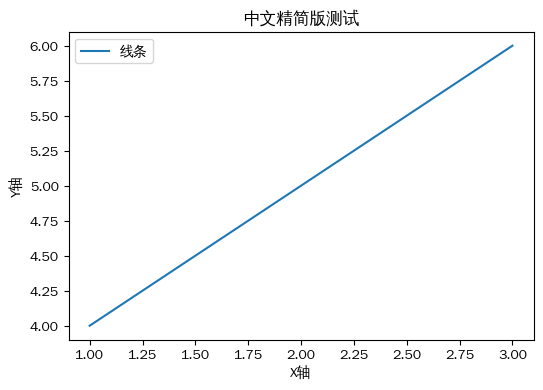

In [29]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. 安装字体 (静默模式)
!apt-get -qq install fonts-wqy-zenhei

# 2. 注册并设置字体
fm.fontManager.addfont('/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')
plt.rc('font', family='WenQuanYi Zen Hei')
plt.rc('axes', unicode_minus=False)

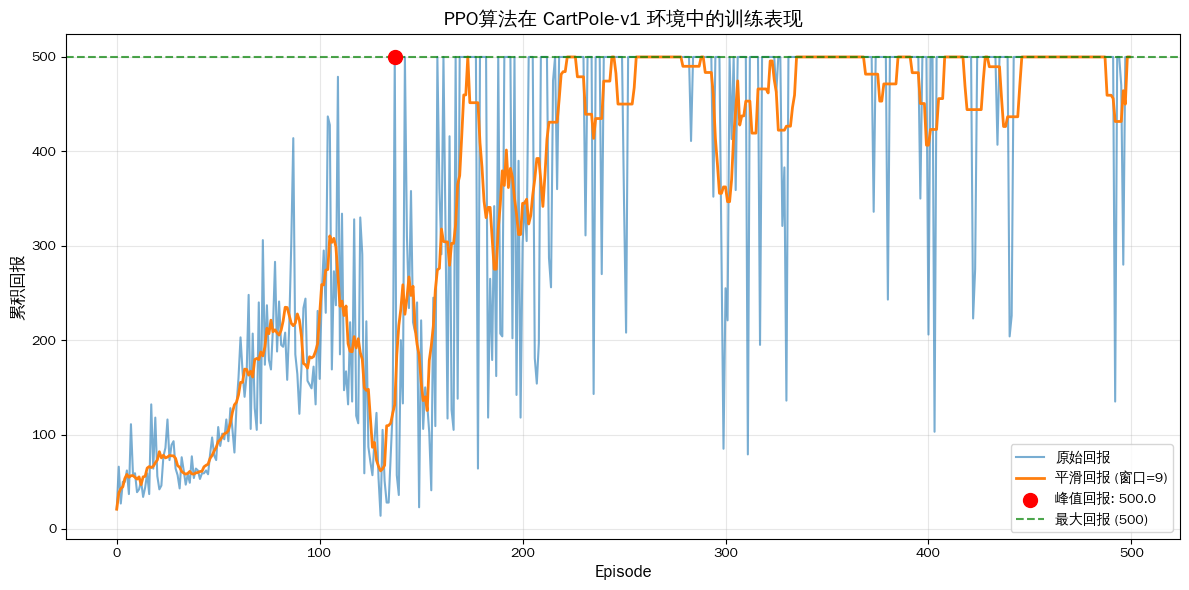


训练统计信息:
- 总Episode数: 500
- 最终平均回报 (最后10个): 438.50
- 峰值回报: 500.00 (Episode 137)
- 最小回报: 14.00
- 训练标准差: 178.13

恭喜！智能体成功解决了 CartPole-v1 环境！
最终性能: 487.70/500 (优秀)


In [37]:
# 可视化训练结果
plt.figure(figsize=(12, 6))

# 原始回报
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list, label='原始回报', alpha=0.6)

# 平滑回报
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return, label='平滑回报 (窗口=9)', linewidth=2)

# 标记关键点
max_return_idx = np.argmax(return_list)
plt.scatter(max_return_idx, return_list[max_return_idx],
           color='red', s=100, zorder=5, label=f'峰值回报: {return_list[max_return_idx]:.1f}')

# 添加参考线
plt.axhline(y=500, color='green', linestyle='--', alpha=0.7, label='最大回报 (500)')

plt.xlabel('Episode', fontsize=12)
plt.ylabel('累积回报', fontsize=12)
plt.title(f'PPO算法在 {env_name} 环境中的训练表现', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图像
plt.savefig('ppo_training_curve.png', dpi=300)
plt.show()

# 打印统计信息
print(f"\n训练统计信息:")
print(f"- 总Episode数: {len(return_list)}")
print(f"- 最终平均回报 (最后10个): {np.mean(return_list[-10:]):.2f}")
print(f"- 峰值回报: {np.max(return_list):.2f} (Episode {np.argmax(return_list)})")
print(f"- 最小回报: {np.min(return_list):.2f}")
print(f"- 训练标准差: {np.std(return_list):.2f}")

# 评估性能
final_avg = np.mean(return_list[-50:])
if final_avg > 475:
    print(f"\n恭喜！智能体成功解决了 {env_name} 环境！")
    print(f"最终性能: {final_avg:.2f}/500 (优秀)")
elif final_avg > 300:
    print(f"\n智能体表现良好，但尚未完全解决环境。")
    print(f"最终性能: {final_avg:.2f}/500 (良好)")
else:
    print(f"\n智能体表现不佳，建议调整超参数或增加训练回合。")
    print(f"最终性能: {final_avg:.2f}/500 (需要改进)")

## 6. 智能体演示（可选）

让我们可视化训练好的智能体在环境中的表现。这有助于直观理解智能体学到的策略。

> **注意**: 这个单元格是可选的，如果只需要训练结果可以跳过。

In [38]:
# %%
# 创建渲染环境进行演示
try:
    demo_env = gym.make(env_name, render_mode="human")  # human模式用于可视化
except Exception as e:
    print(f"无法创建渲染环境: {e}")
    print("跳过演示环节，使用rgb_array模式代替")
    demo_env = gym.make(env_name, render_mode="rgb_array")

state, _ = demo_env.reset(seed=42)
done = False
total_reward = 0
step_count = 0

print("开始演示训练好的智能体...")
print("提示: 关闭渲染窗口或按Ctrl+C停止演示")

try:
    while not done and step_count < 1000:  # 限制最大步数以防无限循环
        action = agent.take_action(state)
        next_state, reward, terminated, truncated, _ = demo_env.step(action)
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1

        # 显示当前状态（可选）
        if step_count % 50 == 0:
            print(f"  - 已运行 {step_count} 步, 当前累积奖励: {total_reward:.1f}")

    print(f"\n演示结束!")
    print(f"- 总步数: {step_count}")
    print(f"- 累积奖励: {total_reward:.1f}")
    print(f"- 状态: {'成功平衡!' if total_reward >= 475 else '未能完全平衡'}")

except KeyboardInterrupt:
    print("\n用户中断演示")
finally:
    demo_env.close()

开始演示训练好的智能体...
提示: 关闭渲染窗口或按Ctrl+C停止演示
  - 已运行 50 步, 当前累积奖励: 50.0
  - 已运行 100 步, 当前累积奖励: 100.0
  - 已运行 150 步, 当前累积奖励: 150.0
  - 已运行 200 步, 当前累积奖励: 200.0
  - 已运行 250 步, 当前累积奖励: 250.0
  - 已运行 300 步, 当前累积奖励: 300.0
  - 已运行 350 步, 当前累积奖励: 350.0
  - 已运行 400 步, 当前累积奖励: 400.0
  - 已运行 450 步, 当前累积奖励: 450.0
  - 已运行 500 步, 当前累积奖励: 500.0

演示结束!
- 总步数: 500
- 累积奖励: 500.0
- 状态: 成功平衡!


## 7. 总结与下一步

### 本次训练成果
**成功训练**了一个PPO智能体，在CartPole-v1环境中达到优秀性能  
**掌握**了Gymnasium环境的使用和PPO算法的核心实现  
**理解**了Actor-Critic架构和PPO截断机制的工作原理  

### 关键收获
- **算法理解**: PPO通过截断机制平衡了探索与利用
- **工程实践**: Gymnasium API适配、数据处理优化
- **调试技巧**: 学习曲线分析、超参数调整

### 下一步建议
1. **超参数调优**: 尝试不同的学习率、ε值、GAE参数
2. **环境扩展**: 尝试更复杂的环境（如LunarLander、MountainCar）
3. **算法改进**:
   - 实现PPO-Penalty版本
   - 尝试其他算法（如SAC、TD3）
4. **部署应用**: 将训练好的模型保存并部署到实际应用中

### 资源推荐
- [Gymnasium官方文档](https://gymnasium.farama.org/)
- [PPO原论文](https://arxiv.org/abs/1707.06347)
- [Spinning Up in Deep RL](https://spinningup.openai.com/)

In [33]:
# 保存训练好的模型（可选）
import os
os.makedirs('models', exist_ok=True)

# 保存策略网络
torch.save(agent.actor.state_dict(), 'models/ppo_actor_cartpole.pth')
torch.save(agent.critic.state_dict(), 'models/ppo_critic_cartpole.pth')

print("💾 模型已保存到 'models/' 目录")
print("- 策略网络: ppo_actor_cartpole.pth")
print("- 价值网络: ppo_critic_cartpole.pth")

💾 模型已保存到 'models/' 目录
- 策略网络: ppo_actor_cartpole.pth
- 价值网络: ppo_critic_cartpole.pth


# 连续动作PPO (Proximal Policy Optimization) 强化学习教程
## 在 Pendulum 倒立摆环境中训练智能体

本教程将带你实现**连续动作空间**的PPO算法，在经典的Pendulum倒立摆环境中训练一个能够平衡摆臂的智能体。与离散动作不同，连续动作控制需要智能体输出精确的力矩值，这在机器人控制等实际应用中更为常见。

> **核心挑战**：在连续动作空间中，智能体需要学习输出概率分布（高斯分布）的参数，而不是简单的动作概率。这增加了算法的复杂性，但也使其更适用于真实世界的控制任务。

## 1. 连续动作PPO算法实现

### 连续动作空间的特殊性
在倒立摆环境中：
- **动作空间**: 连续值 [-2.0, 2.0]，表示施加在摆臂上的力矩
- **挑战**: 不能简单地输出每个动作的概率，而需要输出**概率分布**的参数
- **解决方案**: 使用高斯分布，输出均值(μ)和标准差(σ)

### 策略网络设计
PolicyNetContinuous:
- **输入**: 状态 (3维)
- **隐藏层**: 128个神经元 (ReLU激活)
输出:
- **μ (均值)**: 通过tanh限制在[-2, 2]范围内
- **σ (标准差)**: 通过softplus确保为正数

### PPO-Continuous核心机制
1. **高斯分布采样**: 从 N(μ, σ²) 中采样连续动作
2. **奖励归一化**: `(reward + 8.0) / 8.0` 将奖励缩放到合理范围
3. **重要性采样**: 计算新旧策略的比率，确保稳定更新
4. **截断机制**: 限制策略更新幅度，防止性能崩溃

> **关键区别**：连续动作PPO需要处理动作的**概率密度**，而不是离散动作的概率。

In [125]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

class ValueNet(nn.Module):
    """价值网络 (Critic): 估计状态价值函数 V(s)
    这个网络在离散和连续动作PPO中是相同的"""
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_) # 增添应用正交初始化

    def forward(self, x):
        """前向传播"""
        # x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc1(x)) # 使用tanh激活函数通常比relu函数更稳
        return self.fc2(x)

# 定义一个正交初始化的辅助函数
def weights_init_(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
    torch.nn.init.constant_(m.bias, 0.0)

class PolicyNetContinuous(nn.Module):
    """连续动作策略网络 (Actor): 输出高斯分布的均值和标准差"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)  # 共享隐藏层
        self.fc_mu = nn.Linear(hidden_dim, action_dim)  # 均值输出层
        self.fc_std = nn.Linear(hidden_dim, action_dim)  # 标准差输出层

        self.apply(weights_init_) # 增添应用正交初始化

    def forward(self, x):
        """前向传播，输出高斯分布参数"""
        # x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc1(x)) # 使用tanh激活函数通常比relu函数更稳
        # 均值: 通过tanh限制在[-2, 2]范围内，乘以2.0扩大范围
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        # 标准差: 通过softplus确保为正数，并添加小常数防止为0
        # std = F.softplus(self.fc_std(x)) + 1e-6
        log_std = torch.tanh(self.fc_std(x))
        std = log_std.exp().expand_as(mu)

        return mu, std

class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device,
                 initial_entropy_coef=0.01, final_entropy_coef=0.001): # 新增两个熵参数
        """
        初始化连续动作PPO智能体

        参数:
        state_dim: 状态维度
        hidden_dim: 隐藏层维度
        action_dim: 动作维度 (连续动作空间)
        actor_lr: 策略网络学习率
        critic_lr: 价值网络学习率
        lmbda: GAE参数
        epochs: 每条轨迹的训练轮数
        eps: PPO截断范围参数
        gamma: 折扣因子
        device: 计算设备 (CPU/GPU)
        """
        # 创建网络
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        # 优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        # 新增"保存初始学习率，手动衰减"
        self.initial_actor_lr = actor_lr
        self.initial_critic_lr = critic_lr

        # 新增：保存熵的初始值和目标值
        self.initial_entropy_coef = initial_entropy_coef
        self.final_entropy_coef = final_entropy_coef
        self.current_entropy_coef = initial_entropy_coef # 当前使用的熵系数

        # 算法参数
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 每条轨迹训练轮数
        self.eps = eps  # PPO截断范围 [1-ε, 1+ε]
        self.device = device

    # 新增函数用来更新学习率
    def lr_decay(self, total_steps, current_step):
      decay_ratio = 1.0 - (current_step / total_steps)
      # decay_ratio = max(decay_ratio, 0.0)

      # 更新 Actor LR
      lr_a = self.initial_actor_lr * decay_ratio
      for param_group in self.actor_optimizer.param_groups:
        param_group['lr'] = lr_a

      # 更新 Critic LR
      lr_c = self.initial_critic_lr * decay_ratio
      for param_group in self.critic_optimizer.param_groups:
          param_group['lr'] = lr_c

      # 衰减熵系数 (线性插值)
      # 公式: Current = Initial * ratio + Final * (1 - ratio)
      self.current_entropy_coef = self.initial_entropy_coef * ratio + self.final_entropy_coef * (1 - ratio)

    def take_action(self, state):
        """
        从高斯分布中采样连续动作

        参数:
        state: 当前状态 (numpy数组)

        返回:
        action: 采样的动作 (列表，因为环境期望数组输入)
        """
        # 转换状态为张量（高效处理）
        state = np.array([state])  # 转换为numpy数组
        state = torch.tensor(state, dtype=torch.float).to(self.device)

        with torch.no_grad():
            mu, sigma = self.actor(state)

        # 创建高斯分布并采样
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()

        # 转换为环境需要的格式（Pendulum期望动作是数组）
        return [action.item()]

    def update(self, transition_dict):
        """
        更新策略网络和价值网络

        参数:
        transition_dict: 包含轨迹数据的字典
        """
        # 转换数据为张量（注意：动作现在是连续值）
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # rewards = (rewards + 8.0) / 8.0 # 这种技巧是TRPO原论文针对特定环境设计的，不是通用解决方案
        rewards = rewards * 0.1


        # 计算TD目标和TD误差
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)

        # 计算GAE优势函数
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # 添加优势归一化
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # 保存旧策略的log概率 (重要性采样基准)
        with torch.no_grad():
            mu_old, sigma_old = self.actor(states)
            old_action_dists = torch.distributions.Normal(mu_old, sigma_old)
            old_log_probs = old_action_dists.log_prob(actions)

        # 多次迭代更新（充分利用收集的数据）
        for _ in range(self.epochs):
            # 计算新策略的log概率
            mu_new, sigma_new = self.actor(states)
            new_action_dists = torch.distributions.Normal(mu_new, sigma_new)
            log_probs = new_action_dists.log_prob(actions)
            entropy = new_action_dists.entropy().mean() # 尝试熵正则化，当前策略的熵值

            # 重要性采样比值
            ratio = torch.exp(log_probs - old_log_probs)

            # PPO-Clip损失函数
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            # actor_loss = torch.mean(-torch.min(surr1, surr2))
            actor_loss = torch.mean(-torch.min(surr1, surr2)) - self.current_entropy_coef * entropy  # 最小化负的surrogate目标；减去熵项最大化熵项，在训练初期鼓励探索（高熵），后期鼓励确定性（低熵）

            # 价值网络MSE损失
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 反向传播和优化
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()

            # 新增梯度裁剪
            nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
            nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)

            self.actor_optimizer.step()
            self.critic_optimizer.step()

## 2. Pendulum倒立摆环境介绍

### 环境特性
- **任务**: 控制施加在摆臂底部的力矩，使摆臂竖直向上
- **状态空间 (3维)**:
  - cos(θ): 摆臂角度的余弦值
  - sin(θ): 摆臂角度的正弦值  
  - θ̇: 摆臂角速度
- **动作空间 (1维, 连续)**:
  - 力矩值: [-2.0, 2.0] (单位: Nm)
- **奖励函数**:
  - `-(θ² + 0.1×θ̇² + 0.001×action²)`
  - 目标是最大化奖励（即最小化惩罚）
- **终止条件**:
  - 没有自然终止，只有时间限制（200步）
  - 每个episode固定运行200步

### 挑战与特点
- **连续控制**: 需要输出精确的力矩值，而不是离散动作
- **奖励稀疏**: 只有最终状态提供有用信号，中间奖励都很相似
- **非线性动力学**: 摆臂运动遵循非线性物理规律
- **平衡要求**: 智能体必须学会精确控制，保持摆臂竖直

> **成功标准**: 稳定达到 -200 以上的累积奖励（越接近0越好）

In [126]:
# 设置随机种子以确保可重现性
torch.manual_seed(0)
np.random.seed(0)

# 超参数配置 (针对连续动作优化)
actor_lr = 1e-4        # 策略网络学习率 (较小，确保稳定)
critic_lr = 1e-3       # 价值网络学习率
num_episodes = 6000    # 总训练回合数 (需要更多训练)
hidden_dim = 128       # 神经网络隐藏层维度
gamma = 0.95           # 折扣因子
lmbda = 0.95            # GAE参数
epochs = 10            # 每条轨迹的训练轮数
eps = 0.2              # PPO截断范围
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
entropy_start = 0.01
entropy_end = 0.0005

## 3. 启动训练

现在，我们创建Pendulum环境并开始训练连续动作PPO智能体。由于连续控制问题比离散控制更难，训练过程可能需要更多回合才能收敛。

### 训练特点
- **缓慢收敛**: 连续动作空间更大，需要更多样本来学习
- **奖励归一化**: `(reward + 8.0) / 8.0` 帮助算法更好地处理稀疏奖励
- **稳定更新**: 低学习率和PPO截断机制确保训练稳定性
- **多次训练**: 每条轨迹训练10次(epochs=10)，充分挖掘数据价值

### 预期进展
- **初期**: 智能体表现极差（回报 < -1000）
- **中期**: 逐渐学会基本控制（回报 -500 到 -300）
- **后期**: 接近平衡状态（回报 > -200）
- **最终**: 优秀智能体可达 -130 以上

> **注意**: 由于连续控制的复杂性，训练可能需要2000+个episode才能看到明显改进。

In [127]:
# 创建环境
env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode="rgb_array")  # rgb_array模式适合训练

# 获取环境信息
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间维度

print(f"环境信息:")
print(f"- 环境名称: {env_name}")
print(f"- 状态维度: {state_dim}")
print(f"- 动作维度: {action_dim}")
print(f"- 状态空间: {env.observation_space}")
print(f"- 动作空间: {env.action_space} (范围: {env.action_space.low} 到 {env.action_space.high})")

# 初始化PPO智能体
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device,
            initial_entropy_coef=entropy_start, final_entropy_coef=entropy_end) # 新增两个参数

# 开始训练
print(f"\n开始训练 连续动作PPO 智能体...")
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# 关闭环境
env.close()
print("训练完成！")

环境信息:
- 环境名称: Pendulum-v1
- 状态维度: 3
- 动作维度: 1
- 状态空间: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
- 动作空间: Box(-2.0, 2.0, (1,), float32) (范围: [-2.] 到 [2.])

开始训练 连续动作PPO 智能体...


Iteration 9: 100%|██████████| 600/600 [01:15<00:00,  7.94it/s, episode=6000, return=-706.548]

训练完成！


## 4. 结果分析与可视化

训练完成后，我们分析学习曲线。由于连续控制问题的复杂性，学习曲线可能波动较大，需要仔细分析。

### 关键观察点
- **收敛趋势**: 是否呈现整体上升趋势（负值变小）
- **波动性**: 连续控制通常比离散控制波动更大
- **最终性能**: 最后400个episode的平均回报
- **学习速度**: 需要多少episode才能开始改善

### 性能评估标准
- **优秀**: 平均回报 > -150
- **良好**: 平均回报 > -250
- **一般**: 平均回报 > -400
- **较差**: 平均回报 < -400

> **提示**: 如果结果不理想，可以尝试调整超参数（特别是actor_lr, gamma, eps）或增加训练回合数。

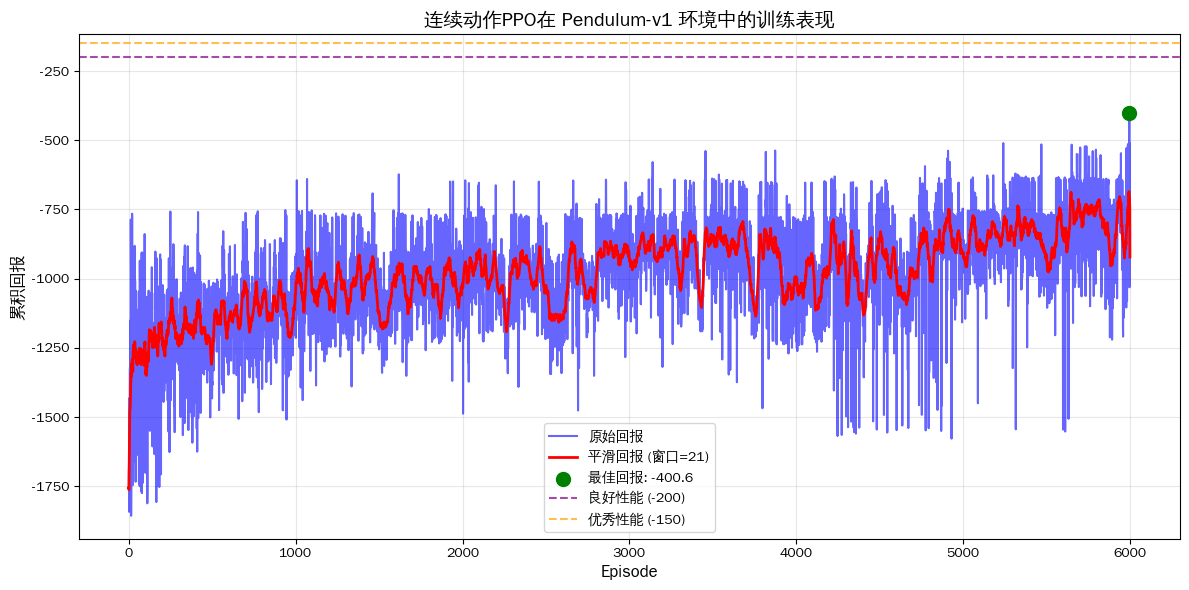


训练统计信息:
- 总Episode数: 6000
- 最终平均回报 (最后400个): -792.96
- 最佳回报: -400.56 (Episode 5995)
- 平均回报 (全部): -979.05
- 训练标准差: 184.85

智能体表现不佳，建议检查算法实现或大幅调整超参数。
最终性能: -792.96

观察: Pendulum环境的奖励是负值，目标是使累积奖励尽可能接近0。

优秀的控制器应该能够将摆臂保持在竖直位置，获得接近0的奖励。


In [128]:
 # 可视化训练结果
plt.figure(figsize=(12, 6))

# 原始回报
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list, label='原始回报', alpha=0.6, color='blue')

# 平滑回报 (使用更大的窗口，因为连续控制波动大)
mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return, label='平滑回报 (窗口=21)', linewidth=2, color='red')

# 标记关键点
best_idx = np.argmax(return_list)  # 注意：回报是负数，所以最大值是最接近0的
plt.scatter(best_idx, return_list[best_idx],
           color='green', s=100, zorder=5, label=f'最佳回报: {return_list[best_idx]:.1f}')

# 添加参考线
plt.axhline(y=-200, color='purple', linestyle='--', alpha=0.7, label='良好性能 (-200)')
plt.axhline(y=-150, color='orange', linestyle='--', alpha=0.7, label='优秀性能 (-150)')

plt.xlabel('Episode', fontsize=12)
plt.ylabel('累积回报', fontsize=12)
plt.title(f'连续动作PPO在 {env_name} 环境中的训练表现', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图像
plt.savefig('pendulum_ppo_training_curve.png', dpi=300)
plt.show()

# 打印统计信息
print(f"\n训练统计信息:")
print(f"- 总Episode数: {len(return_list)}")
print(f"- 最终平均回报 (最后400个): {np.mean(return_list[-400:]):.2f}")
print(f"- 最佳回报: {np.max(return_list):.2f} (Episode {best_idx})")
print(f"- 平均回报 (全部): {np.mean(return_list):.2f}")
print(f"- 训练标准差: {np.std(return_list):.2f}")

# 评估性能
final_avg = np.mean(return_list[-400:])
if final_avg > -150:
    print(f"\n恭喜！智能体在 {env_name} 环境中表现优秀！")
    print(f"最终性能: {final_avg:.2f} (接近0表示更好)")
elif final_avg > -250:
    print(f"\n智能体表现良好，已经学会基本控制。")
    print(f"最终性能: {final_avg:.2f}")
elif final_avg > -400:
    print(f"\n智能体表现一般，需要进一步训练或调整超参数。")
    print(f"最终性能: {final_avg:.2f}")
else:
    print(f"\n智能体表现不佳，建议检查算法实现或大幅调整超参数。")
    print(f"最终性能: {final_avg:.2f}")

print(f"\n观察: Pendulum环境的奖励是负值，目标是使累积奖励尽可能接近0。")
print(f"\n优秀的控制器应该能够将摆臂保持在竖直位置，获得接近0的奖励。")

## 5. 智能体演示与分析

让我们可视化训练好的智能体在环境中的表现，并分析其控制策略。

### 期望行为
- **初期**: 随机摆动，无法保持平衡
- **中期**: 能够短暂平衡，但经常失败
- **后期**: 平稳地将摆臂从任意位置摆到竖直位置并保持

### 常见问题分析
1. **过度震荡**: 智能体输出过大动作，导致摆臂剧烈摆动
   - **原因**: 动作标准差过大，或奖励归一化不当
   - **解决方案**: 调整actor网络的σ输出，或修改奖励归一化

2. **收敛缓慢**: 长时间无法改善性能
   - **原因**: 学习率过低，或探索不足
   - **解决方案**: 增加actor_lr，或在σ输出添加熵正则化

3. **性能不稳定**: 学习曲线波动剧烈
   - **原因**: 批次大小过小，或GAE参数不当
   - **解决方案**: 增加每条轨迹的训练轮数(epochs)，调整lmbda

> **注意**: 由于Pendulum环境没有内置渲染，我们使用rgb_array模式记录状态。

开始演示训练好的智能体...
提示: 按Ctrl+C停止演示，或等待完成
  - 已运行 50 步, 当前累积奖励: -126.3
  - 已运行 100 步, 当前累积奖励: -126.8
  - 已运行 150 步, 当前累积奖励: -127.4
  - 已运行 200 步, 当前累积奖励: -128.0

演示结束!
- 总步数: 200
- 累积奖励: -128.0

控制策略分析:
- 状态范围: cos(θ)=-1.000 到 1.000
            sin(θ)=-0.995 到 0.989
            θ̇=-0.151 到 6.110
- 动作范围: -2.442 到 2.515
- 平均动作幅度: 0.645
- 最终角度: 6.5° (目标: 0°)
- 最终角速度: 0.020 rad/s (目标: 0)
智能体未能完全平衡摆臂，需要进一步训练。


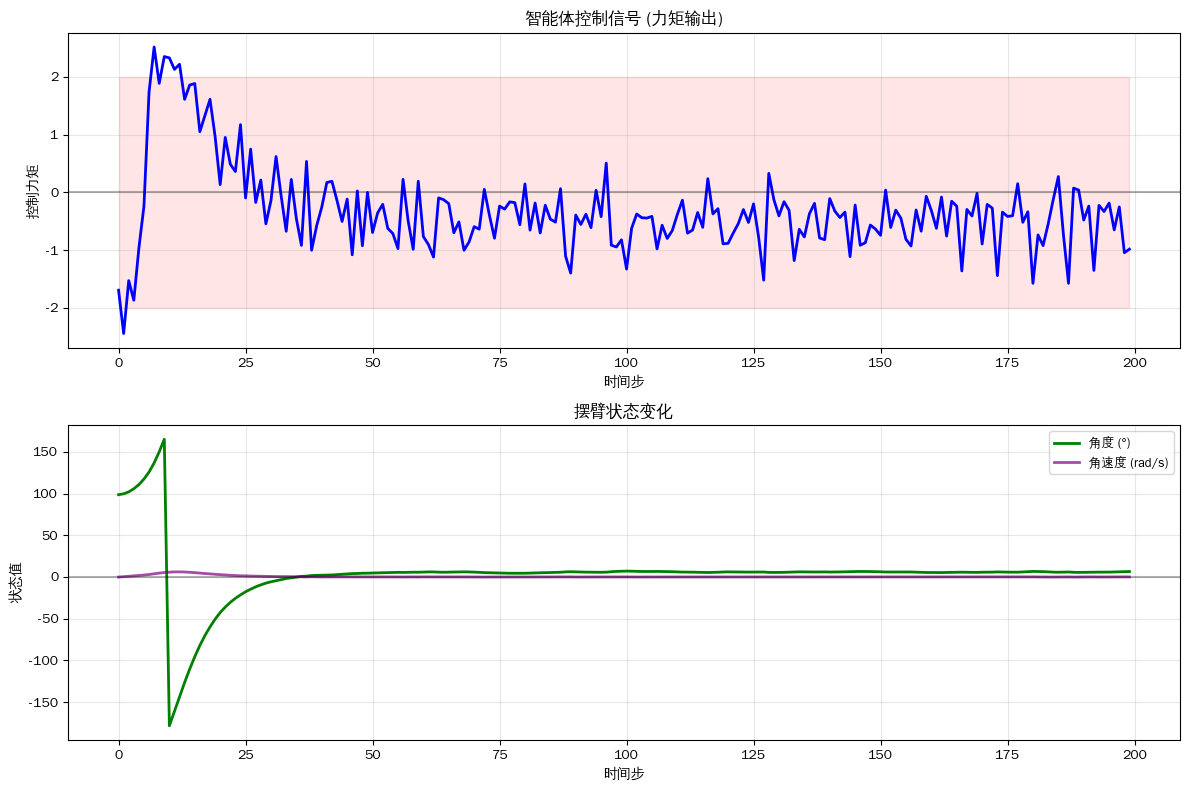

In [115]:
# 创建演示环境
try:
    demo_env = gym.make(env_name, render_mode="human")  # 尝试创建可视化环境
except Exception as e:
    print(f"无法创建渲染环境: {e}")
    print("使用rgb_array模式代替")
    demo_env = gym.make(env_name, render_mode="rgb_array")

# 存储演示数据用于分析
demo_states = []
demo_actions = []
demo_rewards = []

state, _ = demo_env.reset(seed=42)
done = False
total_reward = 0
step_count = 0
max_steps = 500  # 限制最大步数

print("开始演示训练好的智能体...")
print("提示: 按Ctrl+C停止演示，或等待完成")

try:
    while not done and step_count < max_steps:
        action = agent.take_action(state)
        next_state, reward, terminated, truncated, _ = demo_env.step(action)
        done = terminated or truncated

        # 记录数据用于分析
        demo_states.append(state.copy())
        demo_actions.append(action[0])  # 取出单个动作值
        demo_rewards.append(reward)

        state = next_state
        total_reward += reward
        step_count += 1

        # 显示当前状态（每50步）
        if step_count % 50 == 0:
            print(f"  - 已运行 {step_count} 步, 当前累积奖励: {total_reward:.1f}")

    print(f"\n演示结束!")
    print(f"- 总步数: {step_count}")
    print(f"- 累积奖励: {total_reward:.1f}")

    # 关闭环境
    demo_env.close()

    # 分析控制策略
    print(f"\n控制策略分析:")
    demo_states = np.array(demo_states)
    demo_actions = np.array(demo_actions)

    print(f"- 状态范围: cos(θ)={demo_states[:,0].min():.3f} 到 {demo_states[:,0].max():.3f}")
    print(f"            sin(θ)={demo_states[:,1].min():.3f} 到 {demo_states[:,1].max():.3f}")
    print(f"            θ̇={demo_states[:,2].min():.3f} 到 {demo_states[:,2].max():.3f}")
    print(f"- 动作范围: {demo_actions.min():.3f} 到 {demo_actions.max():.3f}")
    print(f"- 平均动作幅度: {np.abs(demo_actions).mean():.3f}")

    # 检查是否达到平衡
    final_angle = np.arctan2(demo_states[-1, 1], demo_states[-1, 0])  # 从sin和cos计算角度
    final_angular_vel = demo_states[-1, 2]
    print(f"- 最终角度: {final_angle*180/np.pi:.1f}° (目标: 0°)")
    print(f"- 最终角速度: {final_angular_vel:.3f} rad/s (目标: 0)")

    if abs(final_angle) < 0.1 and abs(final_angular_vel) < 0.1:
        print("智能体成功将摆臂保持在竖直位置！")
    else:
        print("智能体未能完全平衡摆臂，需要进一步训练。")

except KeyboardInterrupt:
    print("\n用户中断演示")
finally:
    demo_env.close()

# 可视化控制信号
plt.figure(figsize=(12, 8))

# 动作随时间变化
plt.subplot(2, 1, 1)
plt.plot(demo_actions, linewidth=2, color='blue')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.fill_between(range(len(demo_actions)), -2.0, 2.0, alpha=0.1, color='red')
plt.xlabel('时间步', fontsize=10)
plt.ylabel('控制力矩', fontsize=10)
plt.title('智能体控制信号 (力矩输出)', fontsize=12)
plt.grid(True, alpha=0.3)

# 角度和角速度变化
plt.subplot(2, 1, 2)
angles = np.arctan2(demo_states[:, 1], demo_states[:, 0]) * 180 / np.pi  # 转换为角度
plt.plot(angles, label='角度 (°)', linewidth=2, color='green')
plt.plot(demo_states[:, 2], label='角速度 (rad/s)', linewidth=2, color='purple', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('时间步', fontsize=10)
plt.ylabel('状态值', fontsize=10)
plt.title('摆臂状态变化', fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pendulum_control_analysis.png', dpi=300)
plt.show()

In [53]:
# 保存训练好的模型
import os
os.makedirs('models', exist_ok=True)

# 保存策略网络和价值网络
torch.save(agent.actor.state_dict(), 'models/ppo_actor_pendulum.pth')
torch.save(agent.critic.state_dict(), 'models/ppo_critic_pendulum.pth')

print("模型已保存到 'models/' 目录")
print("- 策略网络: ppo_actor_pendulum.pth")
print("- 价值网络: ppo_critic_pendulum.pth")

# 保存训练曲线数据
import pickle
with open('models/pendulum_training_data.pkl', 'wb') as f:
    pickle.dump({
        'returns': return_list,
        'hyperparameters': {
            'actor_lr': actor_lr,
            'critic_lr': critic_lr,
            'num_episodes': num_episodes,
            'hidden_dim': hidden_dim,
            'gamma': gamma,
            'lmbda': lmbda,
            'epochs': epochs,
            'eps': eps
        }
    }, f)

print("训练数据已保存到 'models/pendulum_training_data.pkl'")

模型已保存到 'models/' 目录
- 策略网络: ppo_actor_pendulum.pth
- 价值网络: ppo_critic_pendulum.pth
训练数据已保存到 'models/pendulum_training_data.pkl'


## 6. 总结与迁移学习

### 本教程核心收获
✅ **掌握连续动作空间强化学习**：理解了高斯策略在连续控制中的应用  
✅ **实现PPO-Continuous算法**：从理论到代码的完整实现  
✅ **环境交互与数据处理**：处理Gymnasium API和连续动作的特殊性  
✅ **训练分析与可视化**：评估智能体性能并诊断问题  

### 从Pendulum到实际应用
1. **机械臂控制**:
   - 将学到的力矩控制迁移到多关节机械臂
   - 状态空间扩展到关节角度、速度、力矩

2. **自动驾驶**:
   - 油门/刹车作为连续动作
   - 转向角度作为连续动作

3. **能源管理**:
   - 电力分配作为连续控制问题
   - 温度调节作为连续动作

### 代码复用建议
```python
# 通用连续动作PPO智能体
def create_continuous_ppo_agent(state_dim, action_dim, device):
    return PPOContinuous(
        state_dim=state_dim,
        hidden_dim=128,
        action_dim=action_dim,
        actor_lr=1e-4,
        critic_lr=5e-3,
        lmbda=0.9,
        epochs=10,
        eps=0.2,
        gamma=0.9,
        device=device
    )

# 适用于任意连续动作环境
env = gym.make("YourContinuousEnv-v0")
agent = create_continuous_ppo_agent(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    device=device
)
```


### 后续学习路径
1. **SAC (Soft Actor-Critic)**: 更高效的连续控制算法
2. **DDPG/TD3**: 深度确定性策略梯度算法
3. **模仿学习**: 从专家演示中学习
4. **多智能体强化学习**: 复杂环境中的协作与竞争

> **记住**: 在连续控制领域，**稳定性和样本效率**比最终性能更重要。好的控制器应该在各种初始条件下都能鲁棒地工作。

### 致谢与资源
- [Gymnasium文档](https://gymnasium.farama.org/)
- [PPO原论文](https://arxiv.org/abs/1707.06347)
- [Spinning Up in Deep RL: PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)
- [Deep RL Bootcamp Lecture 6 (Continuous Control)](https://www.youtube.com/watch?v=3TX3k8yH1mk)

**祝你在强化学习的旅程中不断进步！**


这个完整的教程提供了：
1. **详细的理论解释**：连续动作空间的特殊性、高斯策略、奖励归一化
2. **完整的代码实现**：从环境设置到训练、评估和可视化
3. **问题诊断**：常见问题分析和解决方案
4. **改进方向**：超参数调优、算法改进、架构优化
5. **实际应用**：如何将学到的知识迁移到真实世界的连续控制问题
